weather prediction by Viktor L., IKM-220d
enter your values or press Enter to use standart one (Kharkiv, 50th parralel )
enter latitude: 
enter longitude: 
enter start date (year-month-day): 
enter end date (year-month-day): 
entered values: 50.00 36.20 2022-01-01 2023-06-10

calculated error between the predicted and the actual number:  0.03189
coefficient of determination quality of prediction:  0.15109
The predicted precipitation value is: [-0.09226501]



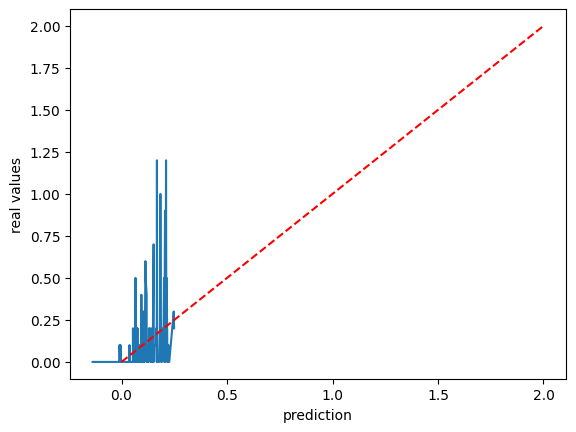

In [2]:
import csv
import numpy as np
import pandas as pd
import seaborn as sns
import requests
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

print ("weather prediction by Viktor L., IKM-220d")
def load_dataset(latitude, longitude, start_date, end_date, code):
    if code == 0: dataset = 'reference_data'
    else: dataset = 'prediction_training_data'
    url = 'https://archive-api.open-meteo.com/v1/archive'
    params = {
        'latitude': latitude,
        'longitude': longitude,
        'start_date': start_date,
        'end_date': end_date,
        'hourly': 'temperature_2m,relativehumidity_2m,surface_pressure,precipitation,cloudcover,'
                 'direct_radiation,diffuse_radiation,windspeed_10m',
        'timezone': 'auto'
    }
    response = requests.get(url, params=params)
    if response.status_code == 200:
        data = response.json()
        time = data['hourly']['time']
        min_temp_2m = data['hourly']['temperature_2m']
        mean_temp_2m = data['hourly']['relativehumidity_2m']
        shortwave_radiation_sum = data['hourly']['surface_pressure']
        precipitation_sum = data['hourly']['precipitation']
        precipitation_hours = data['hourly']['cloudcover']
        windspeed_10m_max = data['hourly']['direct_radiation']
        windgusts_10m_max = data['hourly']['diffuse_radiation']
        winddirection_10m_dominant = data['hourly']['windspeed_10m']

        with open(dataset+'.csv', 'w', newline='') as csvfile:
            writer = csv.writer(csvfile)
            writer.writerow(
                ['time', 'temperature_2m', 'relativehumidity_2m', 'surface_pressure', 'precipitation',
                 'cloudcover', 'direct_radiation', 'diffuse_radiation', 'windspeed_10m'])

            for i in range(len(time)):
                row = [
                    str(time[i])[11:13],
                    min_temp_2m[i],
                    mean_temp_2m[i],
                    shortwave_radiation_sum[i],
                    precipitation_sum[i],
                    precipitation_hours[i],
                    windspeed_10m_max[i],
                    windgusts_10m_max[i],
                    winddirection_10m_dominant[i]
                ]
                writer.writerow(row)
        return '' # return nothing if no errors
    else:
        return 'Error during request complite: ', response.status_code

def prediction(ctrl_data):
    estate_valuation = pd.read_csv('prediction_training_data.csv')
    corr_matrix = estate_valuation.corr()
    sns.heatmap(corr_matrix, annot=True)
    plt.savefig('RESULT_corelation_matrix.png')

    train, test = train_test_split(estate_valuation, test_size=0.25, random_state=42)
    cols = ['time', 'temperature_2m', 'relativehumidity_2m', 'surface_pressure', 'cloudcover', 'direct_radiation', 'diffuse_radiation', 'windspeed_10m']

    xTrain = train[cols]
    xTest = test[cols]
    yTrain = np.array(train['precipitation'])
    yTest = np.array(test['precipitation'])

    linreg = LinearRegression()
    model = linreg.fit(xTrain, yTrain)
    prediction = linreg.predict(xTest)

    MSE = mean_squared_error(yTest, prediction)
    print("calculated error between the predicted and the actual number: ", round(MSE,5))  # lower=better
    DetermCoeff = r2_score(yTest, prediction)
    print("coefficient of determination quality of prediction: ", round(DetermCoeff, 5)) # bigger=better

    x, y = zip(*sorted(zip(prediction, yTest)))
    plt.clf()
    plt.plot(x, y)
    plt.plot([0, 2], [0, 2], '--r')
    plt.xlabel('prediction')
    plt.ylabel('real values')
    plt.savefig('RESULT_graph.png')

    dataNew = pd.DataFrame(
        {"time": [ctrl_data[0]], "temperature_2m": [ctrl_data[1]],
         "relativehumidity_2m": [ctrl_data[2]],
         "surface_pressure": [ctrl_data[3]], "cloudcover": [ctrl_data[4]],
         "direct_radiation": [ctrl_data[5]],
         "diffuse_radiation": [ctrl_data[6]], "windspeed_10m": [ctrl_data[7]]})

    prediction_value = model.predict(dataNew)
    print("The predicted precipitation value is:", prediction_value)
    return ''

print("enter your values or press Enter to use standart one (Kharkiv, 50th parralel )")
latitude = input("enter latitude: ") or '50.00'
longitude = input("enter longitude: ") or '36.20'
start_date = input("enter start date (year-month-day): ") or '2022-01-01'
end_date = input("enter end date (year-month-day): ") or '2023-06-10'
print("entered values:", latitude, longitude, start_date, end_date)
print(load_dataset(latitude, longitude, start_date, end_date, 0))
print(prediction([12, 5.0, 80, 1000.0, 50, 10.0, 5.0, 8.0])) # control data
